# Training GNS on the 2D Taylor Green Vortex
This tutorial notebook will show how to train a GNS model on the 2D Taylor Green Vortex. It will give a brief overview of LagrangeBench on these topics:
- Datasets and case setup
- Models
- Training tricks and strategies (random-walk noise and pushforward)
- Training and inference

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["JAX_ENABLE_X64"] = "True"

import lagrangebench
import haiku as hk
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib.animation as animation

## Datasets
First thing to do is to load the dataset. The simplest way to do this is by using e.g. the `lagrangebench.data.TGV2D` class for the 2-dimensional Taylor-Green vortex problem. It will automatically download the HDF5 files if they are not found in the respective folder, and it will take care of setting up the dataset. Note that for the validation/test set you need to specify a positive number of rollout steps, e.g. `extra_seq_length=20`. This means that the dataset will not split the trajectory into subsequences and keep whole rollouts for evaluation.

In [2]:
tgv2d_train = lagrangebench.data.TGV2D("train", extra_seq_length=5)  # extra_seq_length=5 will be clear later
tgv2d_valid = lagrangebench.data.TGV2D("valid", extra_seq_length=20)

print(
    f"This is a {tgv2d_train.metadata['dim']}D dataset "
    f"called {tgv2d_train.metadata['case']}.\n"
    f"Train snapshot have shape {tgv2d_train[0][0].shape} (n_nodes, seq_len, xy pos).\n"
    f"Val snapshot have shape {tgv2d_valid[0][0].shape} (n_nodes, rollout, xy pos).\n"
)

This is a 2D dataset called TGV.
Train snapshot have shape (2500, 12, 2) (n_nodes, seq_len, xy pos).
Val snapshot have shape (2500, 26, 2) (n_nodes, rollout, xy pos).



Similarly, for other datasets one can use the respective subclass, for example
```python
rpf_3d_data = lagrangebench.data.RPF3D("train") # 3D Reverse Poiseuille flow
dam_2d_data = lagrangebench.data.DAM2D("train") # 2D Dam break
# etc.
# and in general: 
lagrangebench.data.H5Dataset("train", dataset_path="path/to/dataset")
```

## Models
All models should inherit from [`models.BaseModel`](/lagrangebench/models/base.py), and generally include a `_transform` function for feature engineering and graph building. 

Here we use a small GNS model, with latent dimension of 16 and 4 message passing layers and predicting 2D accelerations. Note that we use a function wrapper beause `haiku.Modules` must be initialized inside `haiku.transform`.


In [3]:
def gns(x):
    return lagrangebench.GNS(
        particle_dimension=tgv2d_train.metadata["dim"],
        latent_size=16,
        blocks_per_step=2,
        num_mp_steps=4,
        particle_type_embedding_size=8,
    )(x)

Then apply `haiku.transform` to the model function

In [4]:
gns = hk.without_apply_rng(hk.transform_with_state(gns))

## Training tricks and strategies
To improve performance and stabilize training we can use a number of tricks and strategies. In this notebook we will cover random-walk noise and pushforward, which are included by default in LagrangeBench. 

### Random-walk noise
Briefly, random-walk noise adds noise to the velocities in the input sequence and adjusts the target positions accordingly. The standard deviation is passed as a parameter, and each noise step is rescaled so that the cumulated noise has the input standard deviation. It applied to GNNs in physics in ["Learning to Simulate Complex Physics with Graph Networks"](https://arxiv.org/abs/2002.09405) by Deepmind (2020).

### Pushforward
Instead of training always on the next step, the pushforward trick will randomly sample a number of "unroll" steps to perform and compute the loss only on the last one. Ideally this should inject the "right amount" of noise, since it comes from the physical distribution. Because it adds some overhead, the maximum number of unroll steps should not be too large and the probability of unrolling large sequences should be reasonably small. It comes from ["Message Passing Neural PDE Solvers"](https://arxiv.org/pdf/2202.03376.pdf) by J Brandstetter et al. (2022).

In [5]:
noise_std = 3e-4

pf_config = lagrangebench.PushforwardConfig(
    steps=[-1, 500, 700],  # training steps to unlock the relative stage
    unrolls=[0, 2, 5],  # number of unroll steps per stage
    probs=[7, 2, 1],  # relative probabilities to unroll to the relative stage
)

For example, this configuration would apply noise with `std=3e-4` and pushforward with three unroll stages (0, 2 and 5), "unlocking" the second stage after 500 training steps and the third stage after 700 training steps. After 700 steps, 0-step unroll (normal, 1-step training) will happen with a probability of 70%, 2-step unroll with a probability of 20% and finally 5-step unroll with a probability of 10%.

Pushforward up to 5 steps is the reason why we created the training dataset as `lagrangebench.data.TGV2D("train", extra_seq_length=5)`, as or every sample from the dataset we need up to 5 steps of unroll.

## Case
The `CaseSetupFn` is an essential part in LagrangeBench. Most of the operations during training, such as data preprocessing, time integration for the ouput and neighbor computation are managed by `CaseSetupFn`. The easies way to initialize it is through the `lagrangebench.case_builder` function.

In [6]:
bounds = np.array(tgv2d_train.metadata["bounds"])
box = bounds[:, 1] - bounds[:, 0]

tgv2d_case = lagrangebench.case_builder(
    box=box,  # (x,y) array with the world size along each axis. (1.0, 1.0) for 2D TGV
    metadata=tgv2d_train.metadata,  # metadata dictionary
    input_seq_length=6,  # number of consecutive time steps fed to the model
    isotropic_norm=False,  # whether to normalize each dimension independently
    noise_std=noise_std,  # noise standard deviation used by the random-walk noise
)

## Training and inference
Finally, to train GNS on Taylor Green (with noise and pushforward) the `lagrangebench.Trainer` methods comes to hand

In [8]:
trainer = lagrangebench.Trainer(
    model=gns,
    case=tgv2d_case,
    data_train=tgv2d_train,
    data_valid=tgv2d_valid,
    pushforward=pf_config,
    noise_std=noise_std,
    metrics=["mse"],
    n_rollout_steps=20,
    eval_n_trajs=1,
    lr_start=5e-4,
    log_steps=100,
    eval_steps=500,
)

params, state, _ = trainer(step_max=1000)

/home/ggalletti/git/lagrangebench/venv/lib/python3.10/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


0000, train/loss: 2.17808.
0100, train/loss: 0.19394.
0200, train/loss: 0.19751.
0300, train/loss: 0.20027.
0400, train/loss: 0.15017.
0500, train/loss: 0.14875.
{'val/loss': 0.006475041204928584, 'val/mse1': 3.5806455399026536e-06, 'val/mse5': 0.00014116973568971617, 'val/mse10': 0.0009921582776032162, 'val/stdloss': 0.0, 'val/stdmse1': 0.0, 'val/stdmse5': 0.0, 'val/stdmse10': 0.0}
0600, train/loss: 0.02190.
0700, train/loss: 1.62371.
Reallocate neighbors list at step 772
From (2, 21057) to (2, 20557)
0800, train/loss: 0.18237.
Reallocate neighbors list at step 804
From (2, 20557) to (2, 20742)
0900, train/loss: 0.01483.
1000, train/loss: 0.19956.
{'val/loss': 0.003817330574772867, 'val/mse1': 2.793629854284794e-06, 'val/mse5': 9.147089474639231e-05, 'val/mse10': 0.0005903546941926859, 'val/stdloss': 0.0, 'val/stdmse1': 0.0, 'val/stdmse5': 0.0, 'val/stdmse10': 0.0}


Now let's see what the trained GNS can do. First, let's get the test data. As for the validation set, `n_rollout_steps=20`.

In [10]:
tgv2d_test = lagrangebench.TGV2D("test", extra_seq_length=20)

Then let's run then evaluation over 20 timesteps. Here we use three evaluation metrics: __position MSE__ and __Sinkhorn__ distance.

In [11]:
metrics = lagrangebench.infer(
    gns,
    tgv2d_case,
    tgv2d_test,
    params,
    state,
    metrics=["mse", "sinkhorn"],
    eval_n_trajs=1,
    n_rollout_steps=20,
    rollout_dir="rollouts/",
    out_type="pkl",
)["rollout_0"]
rollout = pickle.load(open("rollouts/rollout_0.pkl", "rb"))

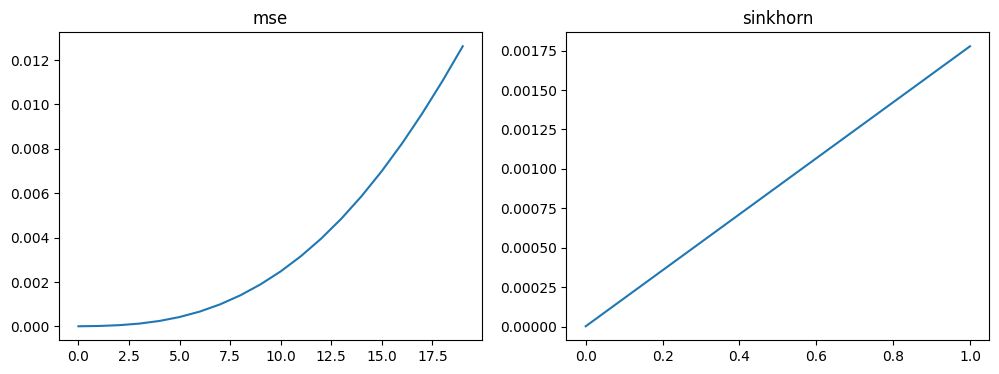

In [12]:
# plot metrics
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# plot the metrics
for i, m in enumerate(["mse", "sinkhorn"]):
    ax[i].plot(metrics[m])
    ax[i].set_title(m)

In [ ]:
print(f"rollout of shape {rollout['predicted_rollout'].shape} (steps, nodes, xy pos)")

fig, ax = plt.subplots(1, 2)
ax[0].set_xlim([0, 1.0])
ax[0].set_ylim([0, 1.0])
ax[1].set_xlim([0, 1.0])
ax[1].set_ylim([0, 1.0])
fig.set_size_inches(10, 5, forward=True)
ax[0].set_title("GNS")
ax[1].set_title("Ground Truth")

rollout_len = rollout["predicted_rollout"].shape[0] - 1

scat0 = ax[0].scatter(
    rollout["predicted_rollout"][0, :, 0], rollout["predicted_rollout"][0, :, 1]
)
scat1 = ax[1].scatter(
    rollout["ground_truth_rollout"][0, :, 0], rollout["ground_truth_rollout"][0, :, 1]
)


def animate(i):
    scat0.set_offsets(rollout["predicted_rollout"][i])
    scat1.set_offsets(rollout["ground_truth_rollout"][i])
    return scat0, scat1


ani = animation.FuncAnimation(
    fig, animate, repeat=True, frames=rollout_len, interval=50
)

plt.close(fig)

writer = animation.PillowWriter(fps=10, metadata=dict(artist="Me"), bitrate=1800)
ani.save("media/scatter.gif", writer=writer)

from IPython.display import Image

Image(url="media/scatter.gif")

rollout of shape (26, 2500, 2) (steps, nodes, xy pos)
